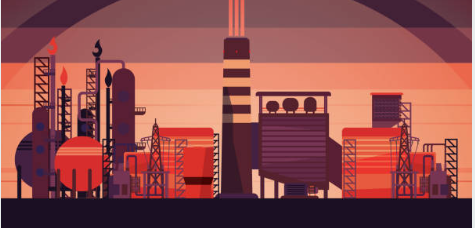

In [1]:
from IPython.display import Image as IPImage, display

display(IPImage(filename="gas.png", width=4000))


''' Problem Statement :-

To develop a machine learning model that accurately predicts Carbon Monoxide (CO) emissions from a gas turbine based on operational parameters such as Ambient Temperature (AT), Ambient Pressure (AP),Turbine Inlet Temperature (TIT), Turbine Energy Yield (TEY), and NOx emissions, using advanced regression algorithms and hyperparameter tuning to improve model performance and deploy the solution via an interactive Gradio interface.
'''

In [3]:
# Import Data Manipulation Library
import pandas as pd
import numpy as np
# Import Data Visualization Library
import seaborn as sns
import matplotlib.pyplot as plt
# Import Filter warnings library
import warnings
warnings.filterwarnings('ignore')
# Import Logging
import logging
logging.basicConfig(level = logging.INFO,
                    format = '%(asctime)s - %(levelname)s - %(message)s',
                    filemode = 'w',
                    filename = 'model.log',force = True)
#Import Scikit learn Libraries for Model Building
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
#Importing Metrics for Regression Model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

import gradio as gr

In [4]:
logging.info('Import Dataset For Model Building...')

In [5]:
# import dataset
df = pd.read_csv('gt_2015.csv')
df.sample(frac = 1)

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
2551,22.9080,1007.2,66.008,3.7720,27.445,1093.5,549.86,141.03,12.632,1.17710,54.879
5795,16.2660,1020.2,72.716,3.2140,23.573,1075.2,550.26,128.61,11.691,2.44070,52.059
4820,22.8060,1017.1,66.053,3.5238,23.178,1071.4,549.67,124.15,11.520,2.94510,53.799
48,3.7958,1021.8,60.910,4.0723,33.994,1099.9,529.04,167.29,14.306,2.67030,61.507
6982,3.0235,1032.6,85.591,2.9419,20.374,1052.3,545.42,118.19,10.887,6.69780,73.605
...,...,...,...,...,...,...,...,...,...,...,...
1660,14.0360,1013.1,36.163,3.3728,30.851,1085.9,550.22,137.92,12.179,2.02950,70.302
5057,27.1940,1012.6,53.672,4.6368,30.104,1100.0,544.31,149.19,13.186,1.98040,57.432
4111,27.7370,1004.0,54.642,4.3049,30.379,1100.1,544.47,148.74,13.257,1.30610,53.336
3338,18.5960,1011.7,70.322,3.7221,26.771,1090.8,549.64,141.04,12.477,1.67660,57.282


In [6]:
# Checking Data Columns
df.columns

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')

# Explorartory Data Analysis

In [8]:
#Dataset informations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7384 entries, 0 to 7383
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      7384 non-null   float64
 1   AP      7384 non-null   float64
 2   AH      7384 non-null   float64
 3   AFDP    7384 non-null   float64
 4   GTEP    7384 non-null   float64
 5   TIT     7384 non-null   float64
 6   TAT     7384 non-null   float64
 7   TEY     7384 non-null   float64
 8   CDP     7384 non-null   float64
 9   CO      7384 non-null   float64
 10  NOX     7384 non-null   float64
dtypes: float64(11)
memory usage: 634.7 KB


<Axes: >

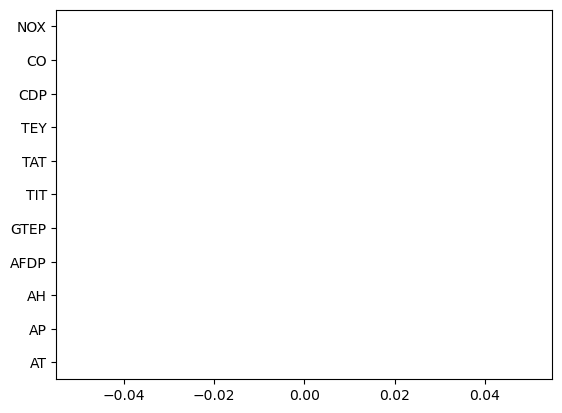

In [9]:
#Checking Null Values stats using Graphical method
df.isnull().sum().plot(kind = 'barh')

In [10]:
#Checking Descriptive Stats: EDA
#Univariate Analysis
from collections import OrderedDict

stats = []
for i in df.columns:
  numerical_stats = OrderedDict({
      'Feature':i,
      'Count':df[i].count(),
      'Mean':df[i].mean(),
      'Median':df[i].median(),
      'Q1':df[i].quantile(0.25),
      'Q3':df[i].quantile(0.75),
      'IQR':df[i].quantile(0.75)-df[i].quantile(0.25),
      'Standard Deviation':df[i].std(),
      'Variance':df[i].var(),
      'Skewness':df[i].skew(),
      'Kurtosis':df[i].kurt()
  })
  stats.append(numerical_stats)
  report = pd.DataFrame(stats)

report

,Feature,Count,Mean,Median,Q1,Q3,IQR,Standard Deviation,Variance,Skewness,Kurtosis
0,AT,7384,17.225259,17.4565,11.073250,23.684750,12.611500,8.095783,65.541708,-0.118255,-0.680877
1,AP,7384,1014.509110,1014.0000,1009.675000,1018.300000,8.625000,6.895430,47.546957,0.392052,0.550273
2,AH,7384,68.647464,70.9520,59.447250,79.653750,20.206500,13.541116,183.361833,-0.542198,-0.467848
3,AFDP,7384,3.598909,3.5385,3.117300,4.194825,1.077525,0.610226,0.372375,0.017480,-1.159660
4,GTEP,7384,26.130149,25.3310,23.147000,30.018250,6.871250,4.473737,20.014320,0.107630,-0.840612
5,TIT,7384,1078.974689,1080.3000,1070.500000,1099.900000,29.400000,19.762449,390.554390,-0.703530,-0.442686
6,TAT,7384,546.642484,549.7200,544.747500,550.030000,5.282500,5.489066,30.129848,-1.915283,3.438691
7,TEY,7384,133.993380,131.6000,126.255000,147.160000,20.905000,16.179208,261.766784,-0.054349,-0.598722
8,CDP,7384,12.097025,11.9330,11.465750,13.148000,1.682250,1.136601,1.291861,0.058759,-0.867770
9,CO,7384,3.129986,2.5334,1.808175,3.702550,1.894375,2.234962,4.995057,3.947098,34.323788


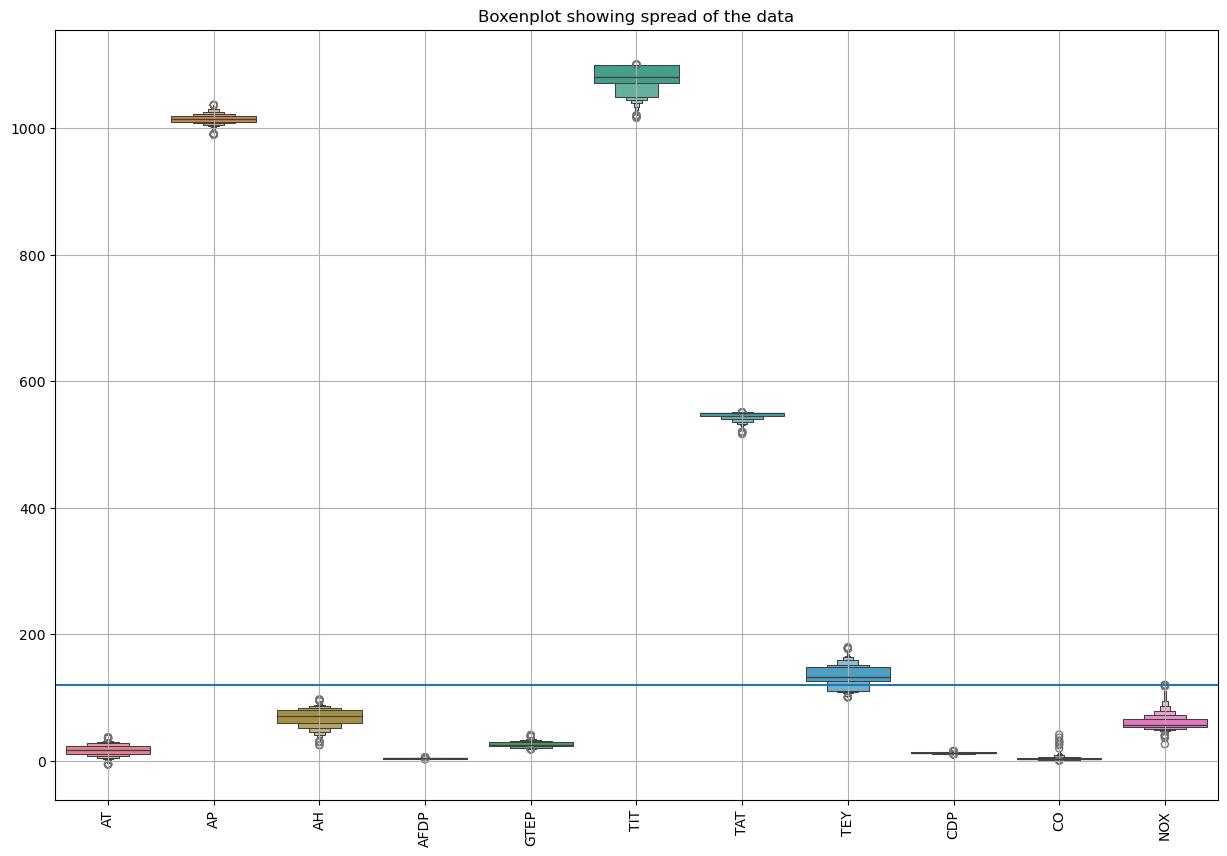

In [11]:
plt.figure (figsize = (15,10))
sns.boxenplot(df)
plt.axhline(120)
plt.xticks(rotation = 90)
plt.title('Boxenplot showing spread of the data')
plt.grid()
plt.show()

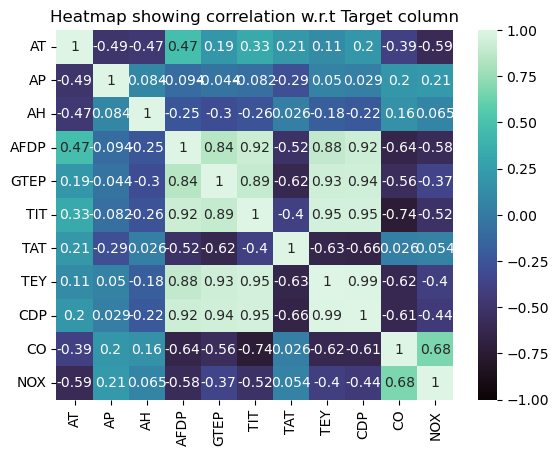

In [12]:
# Heatmap
sns.heatmap(df.corr(),annot = True , center = 0 , vmax = 1 ,vmin = -1 , cmap ='mako')
plt.title('Heatmap showing correlation w.r.t Target column')
plt.show()

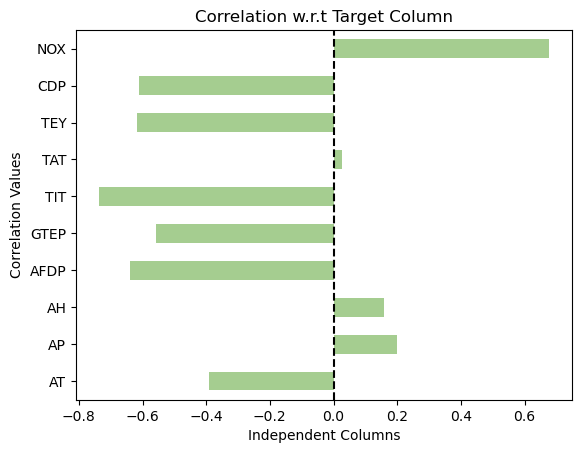

In [13]:
df.corr()['CO'].drop('CO').plot(kind='barh',cmap = 'crest')
plt.axvline(0,linestyle = '--',color='black')
plt.title('Correlation w.r.t Target Column')
plt.ylabel('Correlation Values')
plt.xlabel('Independent Columns')
plt.show()

In [14]:
# Checking Top Five rows of Dataset
'''
1. As the Dataset contains no categorial column, hence no need of converting categorical column to numerical column.
2. No missing value is present in the dataset.
'''
df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491,113.250
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684,112.020
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335,88.147
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972,87.078
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833,82.515


In [15]:
#Preventing Data Leakage

# Step 01: Split the dataset in X and y
# Where X: Independent Column and y: Dependent Column : Target column

X = df.drop(columns ='CO',axis = 1) # drops inside X, but presnt in df
y = df['CO']

# Step 02: Using Train Test Split
#test_size lies between 0.20 to 0.35(20-30 is enough)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

# Step 03: Using Scaling Technique
sc = MinMaxScaler()

#Seen data
X_train = sc.fit_transform(X_train)

# Unseen Data
X_test = sc.transform(X_test)


In [16]:
# Checking VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\n VIF Table:")
print(vif_data.sort_values('VIF', ascending=False))


 VIF Table:
  Feature           VIF
5     TIT  1.674876e+06
6     TAT  8.377694e+05
8     CDP  6.733556e+04
1      AP  4.177732e+04
7     TEY  2.231587e+04
3    AFDP  6.955259e+02
4    GTEP  3.666664e+02
0      AT  8.624823e+01
9     NOX  7.357256e+01
2      AH  5.661348e+01


# Model Building 

In [18]:
#Linear Regression

from sklearn.linear_model import LinearRegression
#Fit model is always on training or seen dataset(test)
LR = LinearRegression().fit(X_train,y_train)
#Prediction value based on Unseen data
y_pred_LR = LR.predict(X_test)
#y_test =  actual, y_pred = predicted
print('Model Accuracy for Linear Regression', r2_score(y_test, y_pred_LR))

Model Accuracy for Linear Regression 0.7237033932588985


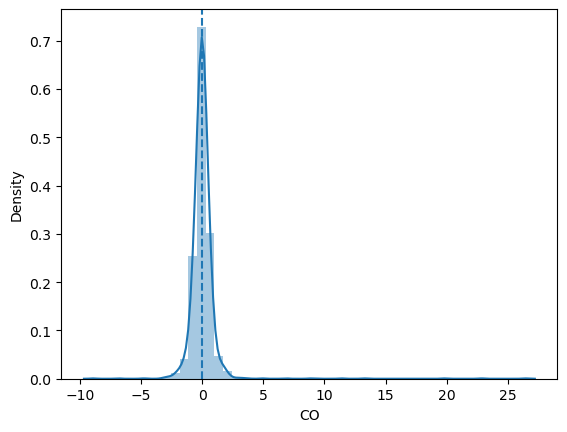

In [19]:
sns.distplot(y_test-y_pred_LR)
plt.axvline(0,linestyle= '--')

Text(0, 0.5, 'Y_pred')

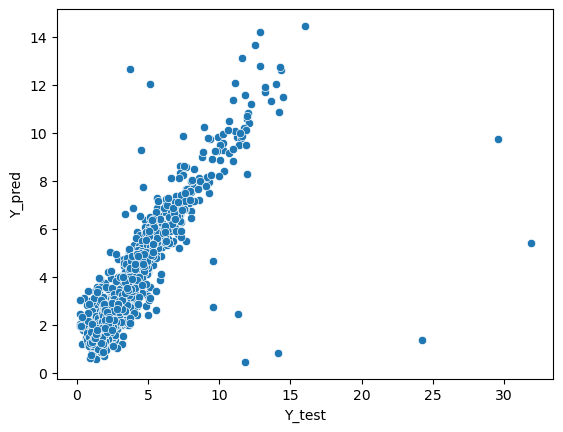

In [20]:
sns.scatterplot(x = y_test , y = y_pred_LR)
plt.xlabel('Y_test')
plt.ylabel('Y_pred')

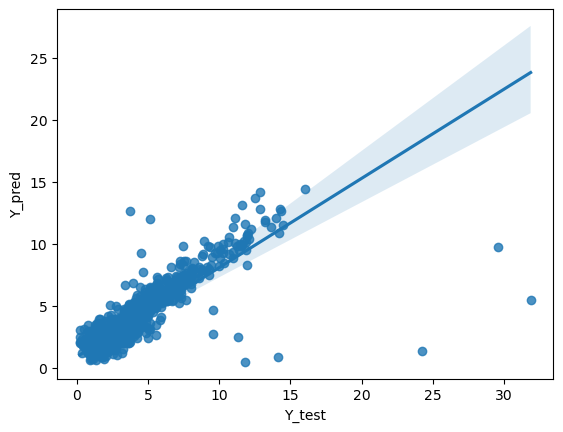

In [21]:
# Model Performance
sns.regplot(x = y_test , y= y_pred_LR) # regression plot
plt.xlabel('Y_test') # actual
plt.ylabel('Y_pred') # predicted value
plt.show() # Some patterns and data points are not captured so accuracy decreases

In [22]:
# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

DT = DecisionTreeRegressor().fit(X_train,y_train)
y_pred_DT = DT.predict(X_test)

print('The Model Accuracy for Decision Tree Regressor', r2_score(y_test,y_pred_DT))

The Model Accuracy for Decision Tree Regressor 0.641855133211529


<Axes: xlabel='CO'>

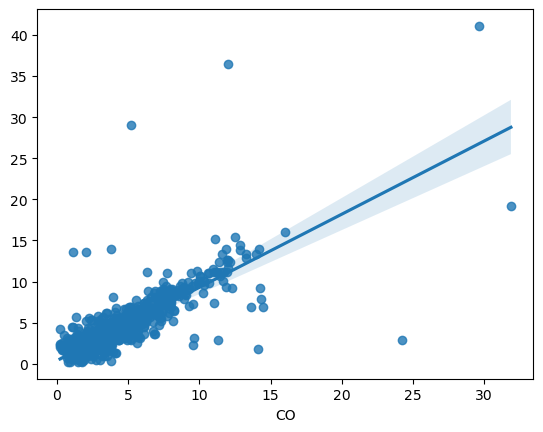

In [23]:
sns.regplot(x= y_test ,y = y_pred_DT)

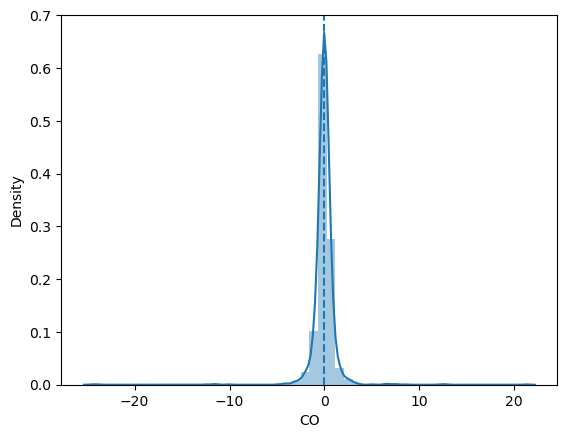

In [24]:
sns.distplot(y_test - y_pred_DT)
plt.axvline(0,linestyle = "--")

# Random Forest Regressor

In [26]:
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor().fit(X_train,y_train)
y_pred_RF = RF.predict(X_test)

print('The Model Accuracy for Decision Tree Regressor',r2_score(y_test,y_pred_RF))

The Model Accuracy for Decision Tree Regressor 0.8135784395813873


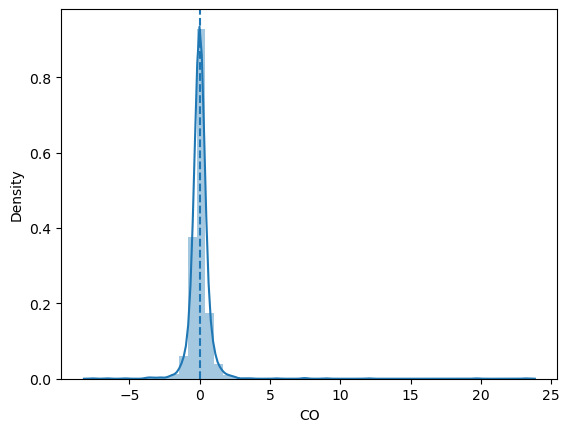

In [27]:
sns.distplot(y_test - y_pred_RF)
plt.axvline(0,linestyle = "--")

In [28]:
import xgboost as xg
xgb = xg.XGBRegressor().fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)
print('Model Accuracy fro XGBoost Regressor',r2_score(y_test,y_pred_xgb))

Model Accuracy fro XGBoost Regressor 0.8158479843589981


In [29]:
!pip install catboost

In [30]:
# CatBoost Algorithm
from catboost import CatBoostRegressor
cat = CatBoostRegressor().fit(X_train,y_train)
y_pred_cat = cat.predict(X_test)

r2_score(y_test,y_pred_cat)

Learning rate set to 0.053074
0:	learn: 2.1402523	total: 143ms	remaining: 2m 23s
1:	learn: 2.0658676	total: 146ms	remaining: 1m 12s
2:	learn: 1.9968133	total: 152ms	remaining: 50.6s
3:	learn: 1.9299031	total: 160ms	remaining: 39.9s
4:	learn: 1.8652425	total: 168ms	remaining: 33.4s
5:	learn: 1.8067767	total: 175ms	remaining: 29.1s
6:	learn: 1.7524089	total: 182ms	remaining: 25.9s
7:	learn: 1.7007725	total: 190ms	remaining: 23.5s
8:	learn: 1.6516534	total: 197ms	remaining: 21.7s
9:	learn: 1.6057375	total: 204ms	remaining: 20.2s
10:	learn: 1.5651331	total: 212ms	remaining: 19s
11:	learn: 1.5253531	total: 219ms	remaining: 18s
12:	learn: 1.4864148	total: 226ms	remaining: 17.2s
13:	learn: 1.4519596	total: 232ms	remaining: 16.4s
14:	learn: 1.4186518	total: 238ms	remaining: 15.6s
15:	learn: 1.3859961	total: 245ms	remaining: 15.1s
16:	learn: 1.3584328	total: 253ms	remaining: 14.6s
17:	learn: 1.3317682	total: 258ms	remaining: 14.1s
18:	learn: 1.3060330	total: 263ms	remaining: 13.6s
19:	learn: 1.

0.8414323130839582

In [31]:
# HuberRegressor
from sklearn.linear_model import HuberRegressor
huber = HuberRegressor().fit(X_train,y_train)
y_pred_huber = huber.predict(X_test)

r2_score(y_test,y_pred_huber)

0.7209941494326436

In [32]:
from sklearn.ensemble import GradientBoostingRegressor
GB = GradientBoostingRegressor().fit(X_train,y_train)
y_pred_GB = GB.predict(X_test)

print(f'The Accuracy score for GradientBoostingRegressor',r2_score(y_test,y_pred_GB))

The Accuracy score for GradientBoostingRegressor 0.771367047596541


In [33]:
#Using KNN Algorithm
from sklearn.neighbors import KNeighborsRegressor
KNN = KNeighborsRegressor().fit(X_train,y_train)
y_pred_KNN = KNN.predict(X_test)

print('Model Accuracy for KNN Regressor', r2_score(y_test,y_pred_KNN))

Model Accuracy for KNN Regressor 0.7426269440934135


In [ ]:
# Model Validation Technique and Finding Best Tuning for Model
from sklearn.model_selection import RandomizedSearchCV

#Initialize the model
RF = RandomForestRegressor(random_state = 42)

#Define hyperparameter grid based on RandomForest Parameters
param_dist = {
    'n_estimators': [100,200,300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'max_features': ['auto','sqrt','log2']
}

#RandomizedSearchCV setup considering Randomsearchcv parameters
random_search = RandomizedSearchCV(
    estimator = RF,
    param_distributions = param_dist,
    n_iter=50,
    cv=5,
    scoring= 'r2',
    random_state = 42,
    n_jobs = -1
)

#Fit to training data
random_search.fit(X_train, y_train)

#Best model
best_rf = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)
print("Best r2 Score on CV:", random_search.best_score_)

In [ ]:
import pandas as pd
import numpy as np
import gradio as gr
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Step 1: Load the dataset
df = pd.read_csv('gt_2015.csv')  # Adjust path if needed

# Step 2: Select features and target
selected_features = ["AT", "AP", "TIT", "TEY", "NOX"]
X = df[selected_features]
y = df["CO"]  #  New target: Carbon Monoxide

# Step 3: Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Tune and train Random Forest
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["auto", "sqrt"]
}
rf = RandomForestRegressor(random_state=42)
search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=10, cv=5, scoring="r2", n_jobs=-1, random_state=42
)
search.fit(X_train_scaled, y_train)
best_rf = search.best_estimator_

# Step 5: Define prediction function for Gradio
def predict_co(AT, AP, TIT, TEY, NOX):
    input_data = np.array([[AT, AP, TIT, TEY, NOX]])
    scaled_input = scaler.transform(input_data)
    prediction = best_rf.predict(scaled_input)
    return round(prediction[0], 3)

# Step 6: Gradio Interface
interface = gr.Interface(
    fn=predict_co,
    inputs=[
        gr.Number(label="Ambient Temperature (AT)"),
        gr.Number(label="Ambient Pressure (AP)"),
        gr.Number(label="Turbine Inlet Temperature (TIT)"),
        gr.Number(label="Turbine Energy Yield (TEY)"),
        gr.Number(label="NOX Emission (NOX)")
    ],
    outputs=gr.Number(label="Predicted CO Emission"),
    title="🌫️ Gas Turbine CO Predictor",
    description="Predict Carbon Monoxide (CO) emissions using turbine parameters and NOX emission."
)

# Launch the app
if __name__ == "__main__":
    interface.launch()
